In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from homography import pyrs12, spaces
import os, cv2, h5py, random, string
import numpy as np
import HandShapeAnalysis
import matplotlib.pyplot as plt
import deproject
import Evaluation_tools
from functools import reduce
from importlib import reload

In [3]:
reload(Evaluation_tools)
reload(HandShapeAnalysis)

<module 'HandShapeAnalysis' from 'E:\\User\\workspace\\multi-touch\\experiement\\HandShapeAnalysis.py'>

In [4]:
if os.name =="nt":
    all_file = !dir /s /b /a-d "./recording"
    ex1data = list(filter(lambda x: (".hdf5" in x)&("ex1" in x),all_file))
    ex2data = list(filter(lambda x: (".hdf5" in x)&("ex2" in x),all_file))
else:
    !ls ./recording
    data1 = '/Users/tom/Documents/multi-touch/experiement/recording/ex1_20190131_170629/Vhdf5_ex1_20190131_170629.hdf5'
    data2 = '/Users/tom/Documents/multi-touch/experiement/recording/ex1_20190131_171115/Vhdf5_ex1_20190131_171115.hdf5'
    data3 = '/Users/tom/Documents/multi-touch/experiement/recording/ex1_20190131_173332/Vhdf5_ex1_20190131_173332.hdf5'


In [5]:
ex2data

['E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190131_171522\\Vhdf5_ex2_20190131_171522.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190131_173820\\Vhdf5_ex2_20190131_173820.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_135613\\Vhdf5_ex2_20190218_135613.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_140706\\Vhdf5_ex2_20190218_140706.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_142214\\Vhdf5_ex2_20190218_142214.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_143252\\Vhdf5_ex2_20190218_143252.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_144338\\Vhdf5_ex2_20190218_144338.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_145546\\Vhdf5_ex2_20190218_145546.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_150854\\Vhdf5_e

In [6]:
def loading(path):
    h5f = h5py.File(path, 'r')
    depth_frame = h5f['depth'][...]
    output = os.path.splitext(path)[0]
    label = np.load(output+".npy")
    pcl_center = h5f['pcl_center'][...]
    trans_matrix = h5f['trans_matrix'][...]
    h5f.close()
    return depth_frame, label, pcl_center, trans_matrix

def depth2cloud(image, mat, org, show = False):
    cloud = deproject.compute(image.astype(np.short()))
    point_original = (np.dot(mat, (cloud - org).reshape((-1,3)).T).T)
    # if show: plt.imshow(point[image != 0].reshape((-1,3)))
    return point_original#, point[without_table].reshape((-1,3))

def test_homography(path):
    import pptk, deproject
    h5f = h5py.File(path, 'r')
    print(list(h5f.keys()))
    depth_frame = h5f['depth'][...]
    pcl_center = h5f['pcl_center'][...]
    trans_matrix = h5f['trans_matrix'][...]
#     for i in depth_frame:
#         plt.imshow(i)
#         plt.show()
    h5f.close()
    pptk.viewer(depth2cloud(depth_frame[0], trans_matrix,pcl_center, show = False))
def find_point(image, point):
    analyser2.renew_depth(depth_frame[i])
    cloud_image = np.where((analyser2.cloud[:,:,2]>0.01).reshape(analyser2.cloud.shape[0],analyser2.cloud.shape[1],1),
             analyser2.cloud, np.zeros((3,)))
    x = HandShapeAnalysis.search_closest_nonzero(point, cloud_image)
    return x
def auto_ex1_analysis(path_list, new_parameter=False, debug = True):
    result = []
    analyser2 = HandShapeAnalysis.Depth2Finger(1, 1)
    analyser2.set_show(debug=False,
                   finger_point_image=True, hull_image=True, detected_defect=True, cluster_point=True, possibility_modal=False)
    analyser2.RANSAC = True
    analyser2.RANSAC_threshold = 5e-3
    analyser2.RANSAC_iterations = 100
#     _, _, pc, tm = loading(path_list[5])
    for i in path_list:
        print("-------------------------")
        print(i)
        print("-------------------------")
        
        df, l, pc1, tm2 = loading(i)
        analyser2.pcl_center = pc1
        analyser2.trans_matrix = tm2
        result.append(Evaluation_tools.Confusion_Matrix(df, l, range(len(df)),analyser=analyser2, new_parameter=new_parameter,debug = debug))
    return result
def auto_ex1_evalution(result_list, path_list):
    all_ = Evaluation_tools.Confusion()
    part_ = Evaluation_tools.Confusion()
    finger_ = [Evaluation_tools.Confusion(),Evaluation_tools.Confusion(),Evaluation_tools.Confusion(),Evaluation_tools.Confusion(),Evaluation_tools.Confusion()]
    for i in range(len(result_list)):
        Matrix, distance, finger = result_list[i]
        if(Matrix.FP>Matrix.TP):
            print(path_list[i]+" have problem")
        else:
            part_ = part_.combine(Matrix)
        finger_[0] = finger_[0].combine(finger[0])
        finger_[1] = finger_[1].combine(finger[1])
        finger_[2] = finger_[2].combine(finger[2])
        finger_[3] = finger_[3].combine(finger[3])
        finger_[4] = finger_[4].combine(finger[4])
        all_ = all_.combine(Matrix)
        Matrix.show()
    print("all")
    all_.show()
    print("Broken filter")
    part_.show()
    for i in finger_:
        i.show()
    
def loading_touch(path):
    h5f = h5py.File(path, 'r')
    depth_frame = h5f['depth'][...]
    pcl_center = h5f['pcl_center'][...]
    trans_matrix = h5f['trans_matrix'][...]
    
    output = os.path.splitext(path)[0]
    label_point = np.load(output+".npy")##auctal point
    
#     directory = os.path.dirname(path)
#     label_label = np.load(directory+"/show_touch_tuple.npy")##indexed finger
    
    directory = os.path.dirname(path)
    label_and_istouch = np.load(directory+"/label_and_istouch.npy")##label_and_istouch
    
    
    new_depth_frame = []
    for i in range(len(depth_frame)):
        if(len(label_point[i])!=0):
            new_depth_frame.append(depth_frame[i])
    h5f.close()
    
#     new_depth_frame = []
#     new_label_point = []
#     all_= 0 
#     label_istouch = []#boolean array of whether the label is touching
#     for i in range(len(depth_frame)):
#         new = []
#         if(len(label_point[i])!=0):
#             new_depth_frame.append(depth_frame[i])
#             new_label_point.append(label_point[i][label_point[i][:,0].argsort()[::-1]])
#             for index in label_label[i][0]:
#                 new.append(index in label_label[i][1])
#             label_istouch.append(new)
#         all_ +=(len(new)) 
#     h5f.close()
#     print(all_)
    return np.array(new_depth_frame), label_and_istouch[0], label_and_istouch[1], pcl_center, trans_matrix

In [7]:
ex1data

['E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex1_20190131_171115\\Vhdf5_ex1_20190131_171115.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex1_20190131_173332\\Vhdf5_ex1_20190131_173332.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex1_20190218_135216\\Vhdf5_ex1_20190218_135216.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex1_20190218_140309\\Vhdf5_ex1_20190218_140309.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex1_20190218_141819\\Vhdf5_ex1_20190218_141819.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex1_20190218_142850\\Vhdf5_ex1_20190218_142850.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex1_20190218_143926\\Vhdf5_ex1_20190218_143926.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex1_20190218_145137\\Vhdf5_ex1_20190218_145137.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex1_20190218_150446\\Vhdf5_e

In [8]:
ex2data

['E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190131_171522\\Vhdf5_ex2_20190131_171522.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190131_173820\\Vhdf5_ex2_20190131_173820.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_135613\\Vhdf5_ex2_20190218_135613.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_140706\\Vhdf5_ex2_20190218_140706.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_142214\\Vhdf5_ex2_20190218_142214.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_143252\\Vhdf5_ex2_20190218_143252.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_144338\\Vhdf5_ex2_20190218_144338.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_145546\\Vhdf5_ex2_20190218_145546.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_150854\\Vhdf5_e

In [9]:
reload(Evaluation_tools)
reload(HandShapeAnalysis)

<module 'HandShapeAnalysis' from 'E:\\User\\workspace\\multi-touch\\experiement\\HandShapeAnalysis.py'>

In [10]:
# result_ex1_new_parameter = auto_ex1_analysis(ex1data, new_parameter=True, debug=True)

-------------------------
E:\User\workspace\multi-touch\experiement\recording\ex1_20190131_171115\Vhdf5_ex1_20190131_171115.hdf5
-------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.67it/s]


-------------------------
E:\User\workspace\multi-touch\experiement\recording\ex1_20190131_173332\Vhdf5_ex1_20190131_173332.hdf5
-------------------------


 10%|████████▎                                                                          | 5/50 [00:02<00:23,  1.92it/s]E:\User\workspace\multi-touch\experiement\HandShapeAnalysis.py:442: RuntimeWarning: invalid value encountered in arccos
  Angel_A = np.arccos((b_distance + c_distance - a_distance)/(2 * np.sqrt(b_distance) * np.sqrt(c_distance))) * (180 / np.pi)
E:\User\workspace\multi-touch\experiement\HandShapeAnalysis.py:443: RuntimeWarning: invalid value encountered in less
  isfinger = Angel_A < angel
 22%|██████████████████                                                                | 11/50 [00:05<00:19,  2.00it/s]E:\User\workspace\multi-touch\experiement\HandShapeAnalysis.py:677: RuntimeWarning: invalid value encountered in true_divide
  normal = np.divide(normal, np.linalg.norm(normal))
E:\User\workspace\multi-touch\experiement\HandShapeAnalysis.py:682: RuntimeWarning: invalid value encountered in less_equal
  inliers = distances <= threshold
 80%|███████████████████████████

40
can't detect any finger


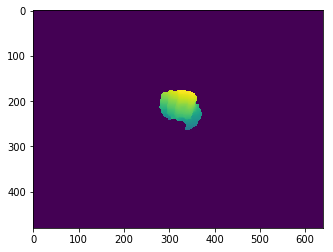

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.89it/s]


-------------------------
E:\User\workspace\multi-touch\experiement\recording\ex1_20190218_135216\Vhdf5_ex1_20190218_135216.hdf5
-------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.61it/s]


-------------------------
E:\User\workspace\multi-touch\experiement\recording\ex1_20190218_140309\Vhdf5_ex1_20190218_140309.hdf5
-------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


-------------------------
E:\User\workspace\multi-touch\experiement\recording\ex1_20190218_141819\Vhdf5_ex1_20190218_141819.hdf5
-------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.33it/s]


-------------------------
E:\User\workspace\multi-touch\experiement\recording\ex1_20190218_142850\Vhdf5_ex1_20190218_142850.hdf5
-------------------------


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]E:\User\workspace\multi-touch\experiement\HandShapeAnalysis.py:185: RuntimeWarning: invalid value encountered in true_divide
  image = (image/np.max(image))*255##use z axis
E:\User\workspace\multi-touch\experiement\HandShapeAnalysis.py:256: RuntimeWarning: invalid value encountered in true_divide
  new = roi_point[:,:,2]/np.max(roi_point[:,:,2])*255
E:\User\workspace\multi-touch\experiement\HandShapeAnalysis.py:257: RuntimeWarning: invalid value encountered in greater
  new = np.where((new>10) & (image!= 0) & roi,new,0).astype(np.uint8)


0
can't detect any finger


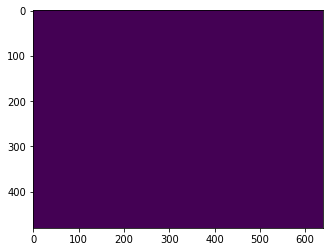

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.21it/s]


-------------------------
E:\User\workspace\multi-touch\experiement\recording\ex1_20190218_143926\Vhdf5_ex1_20190218_143926.hdf5
-------------------------


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:28<00:12,  1.20it/s]

35
can't detect any finger


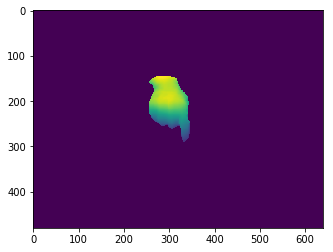

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.23it/s]


-------------------------
E:\User\workspace\multi-touch\experiement\recording\ex1_20190218_145137\Vhdf5_ex1_20190218_145137.hdf5
-------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.52it/s]


-------------------------
E:\User\workspace\multi-touch\experiement\recording\ex1_20190218_150446\Vhdf5_ex1_20190218_150446.hdf5
-------------------------


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0
can't detect any finger


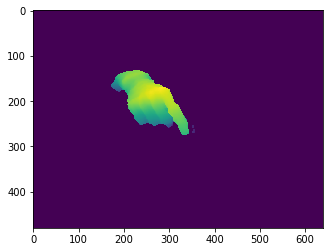

 34%|███████████████████████████▉                                                      | 17/50 [00:11<00:21,  1.52it/s]

17
can't detect any finger


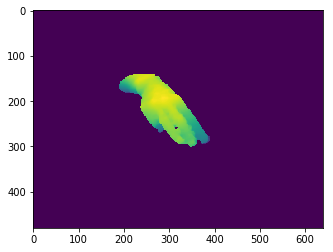

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.52it/s]


-------------------------
E:\User\workspace\multi-touch\experiement\recording\ex1_20190218_151452\Vhdf5_ex1_20190218_151452.hdf5
-------------------------


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:27<00:02,  1.75it/s]

46
can't detect any finger


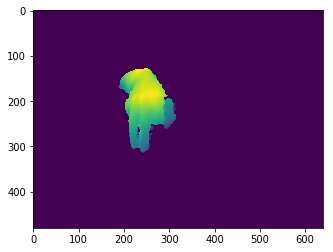

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.71it/s]


-------------------------
E:\User\workspace\multi-touch\experiement\recording\ex1_20190218_152409\Vhdf5_ex1_20190218_152409.hdf5
-------------------------


 20%|████████████████▍                                                                 | 10/50 [00:06<00:24,  1.61it/s]

10
can't detect any finger


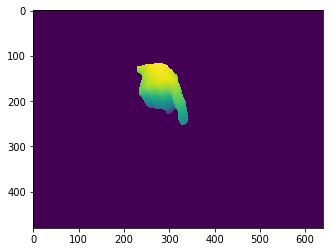

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:21<00:09,  1.55it/s]

35
can't detect any finger


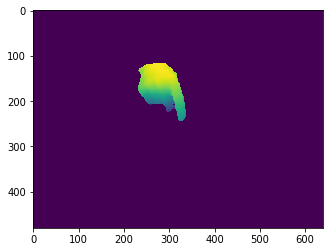

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.49it/s]


-------------------------
E:\User\workspace\multi-touch\experiement\recording\ex1_20190218_154025\Vhdf5_ex1_20190218_154025.hdf5
-------------------------


 10%|████████▎                                                                          | 5/50 [00:03<00:30,  1.47it/s]

5
can't detect any finger


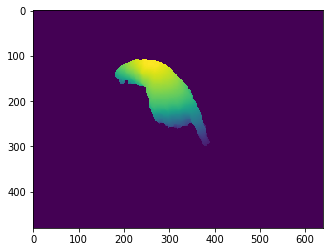

 20%|████████████████▍                                                                 | 10/50 [00:07<00:28,  1.39it/s]

10
can't detect any finger


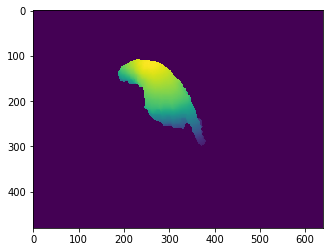

 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:20<00:13,  1.44it/s]

30
can't detect any finger


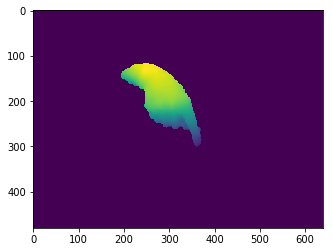

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:24<00:10,  1.45it/s]

35
can't detect any finger


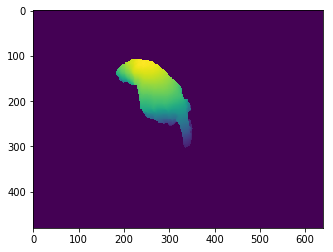

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.46it/s]


-------------------------
E:\User\workspace\multi-touch\experiement\recording\ex1_20190218_155443\Vhdf5_ex1_20190218_155443.hdf5
-------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


In [11]:
result_ex1_oldparameter = auto_ex1_analysis(ex1data, new_parameter=False, debug=False)

In [26]:
0# def loading(path):
#     output = os.path.splitext(path)[0]
#     label = np.load(output+".npy")
#     return 150

# list_total = list(map(lambda x:loading(x), ex1data))
# true_label_num = reduce((lambda x, y:x+y), list_total)

0

# experiment 1 result summary

In [27]:
# auto_ex1_evalution(result_ex1_new_parameter, ex1data)

In [31]:
auto_ex1_evalution(result_ex1_oldparameter, ex1data)

Total detection: 180
real_tn        : 149
True  Positive : 146
False Positive : 34
True  Negative : 0
False Negative : 3
recall : 0.979866
precision : 0.811111

Total detection: 164
real_tn        : 141
True  Positive : 135
False Positive : 29
True  Negative : 0
False Negative : 6
recall : 0.957447
precision : 0.823171

Total detection: 203
real_tn        : 152
True  Positive : 144
False Positive : 59
True  Negative : 0
False Negative : 8
recall : 0.947368
precision : 0.709360

Total detection: 162
real_tn        : 150
True  Positive : 122
False Positive : 40
True  Negative : 0
False Negative : 28
recall : 0.813333
precision : 0.753086

Total detection: 162
real_tn        : 146
True  Positive : 124
False Positive : 38
True  Negative : 0
False Negative : 22
recall : 0.849315
precision : 0.765432

Total detection: 147
real_tn        : 150
True  Positive : 112
False Positive : 35
True  Negative : 0
False Negative : 38
recall : 0.746667
precision : 0.761905

E:\User\workspace\multi-touch\e

In [29]:
def hist_ex1(result_list, path_list):
    sum_fnum = [Evaluation_tools.Confusion() for i in range(5)]
    list_fnum = [[] for i in range(5)]
    data = []
    for i in range(len(result_list)):
        Matrix, distance, fnum = result_list[i]
        for i in range(5):
            sum_fnum[i] = sum_fnum[i].combine(fnum[i])#primary data
            list_fnum[i].append(fnum[i])#error bar
            
    #primary data
    for i in sum_fnum:
        i.show()
        data.append(i.TP/i.real_tn)
    #error bar
    max_list = []
    min_list = []
    for i in range(len(list_fnum)):
        x = list(map(lambda x: x.TP/x.real_tn, list_fnum[i]))
        max_list.append(max(x)-data[i])
        min_list.append(data[i]-min(x))
    
    
    error_bar = [min_list,max_list]
    print(error_bar)
    
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

    # We can set the number of bins with the `bins` kwarg
    axs.bar([str(i+1) for i in range(len(data))],data)
    axs.set_title('Recall of detecting multiple fingertip(s) in Experiement 1')
    axs.set_xlabel('Number of fingertip(s)')
    axs.set_ylabel('Recall')   
    axs.set_ylim(0, 1.05)

Total detection: 180
real_tn        : 124
True  Positive : 94
False Positive : 86
True  Negative : 0
False Negative : 30
recall : 0.758065
precision : 0.522222

Total detection: 307
real_tn        : 252
True  Positive : 204
False Positive : 103
True  Negative : 0
False Negative : 48
recall : 0.809524
precision : 0.664495

Total detection: 422
real_tn        : 375
True  Positive : 296
False Positive : 126
True  Negative : 0
False Negative : 79
recall : 0.789333
precision : 0.701422

Total detection: 554
real_tn        : 492
True  Positive : 399
False Positive : 155
True  Negative : 0
False Negative : 93
recall : 0.810976
precision : 0.720217

Total detection: 799
real_tn        : 640
True  Positive : 545
False Positive : 254
True  Negative : 0
False Negative : 95
recall : 0.851562
precision : 0.682103

[[0.7580645161290323, 0.42063492063492064, 0.456, 0.4359756097560976, 0.42299107142857145], [0.24193548387096775, 0.19047619047619047, 0.21066666666666667, 0.18902439024390238, 0.1484375]

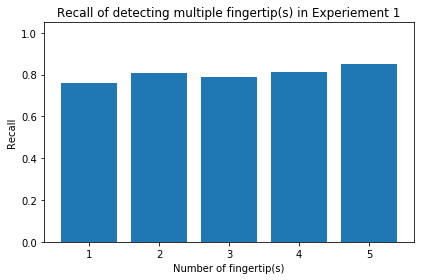

In [30]:
hist_ex1(result_ex1_oldparameter, ex1data)

# second experiment

In [35]:
reload(Evaluation_tools)
reload(HandShapeAnalysis)

<module 'HandShapeAnalysis' from 'E:\\User\\workspace\\multi-touch\\experiement\\HandShapeAnalysis.py'>

In [36]:
def loading_touch(path):
    h5f = h5py.File(path, 'r')
    depth_frame = h5f['depth'][...]
    pcl_center = h5f['pcl_center'][...]
    trans_matrix = h5f['trans_matrix'][...]
    
    output = os.path.splitext(path)[0]
    label_point = np.load(output+".npy")##auctal point
    
    directory = os.path.dirname(path)
    label_label = np.load(directory+"/show_touch_tuple.npy")##indexed finger
    
    
    new_depth_frame = []
    new_label_point = []
    label_istouch = []#boolean array of whether the label is touching
    for i in range(len(depth_frame)):
#         print(i)
#         print(label_point[i])
        if(len(label_point[i])!=0):
            new_depth_frame.append(depth_frame[i])
            new_label_point.append(label_point[i][label_point[i][:,0].argsort()[::-1]])
            new = []
#             print(label_label[i][0])
            for index in label_label[i][0]:
                new.append(index in label_label[i][1])
            label_istouch.append(new)
            if(len(new)!=len(label_point[i])):
                print("Error "+str(i))
    h5f.close()
    
    return np.array(new_depth_frame), np.array(new_label_point), np.array(label_istouch), pcl_center, trans_matrix

In [37]:
def experiment_package(parameter):
    df, lp, lt, pc, tm = parameter
    tips_detection, touch_detection, distance = Evaluation_tools.Confusion_Matrix_touch(df, lp, lt, range(len(df)), 
                                                          pcl_center = pc, trans_matrix = tm, debug = False)

In [38]:
def evaluate_list_file(file,debug=False,new_parameter=False):
    result = []
    from keras.models import load_model
    model = load_model('new_touch_model.hdf5.h5')
    model._make_predict_function()
    for i in file:
        print("======================")
        print(i)
        print("======================")
        df, lp, lt, pc, tm = loading_touch(i)
        analyser = HandShapeAnalysis.Depth2Finger(pc, tm)
        analyser.set_show(debug=False,finger_point_image=True, hull_image=False, detected_defect=True, cluster_point=False, possibility_modal=False)
        analyser.RANSAC = True
        if new_parameter:
            analyser.angel=40
    #         analyser.cloud_min=0.015
            analyser.combine_minimun_distance=0.03
            analyser.cluster_threshold_=30
        result.append(Evaluation_tools.Confusion_Matrix_touch(analyser,model,  df, lp, lt, range(len(df)), debug = debug))
    
    return result
def ex2_result_evaluation(result):
    tips_detection = Evaluation_tools.Confusion()
    touch_detection = Evaluation_tools.Confusion()
    sum_fnum = [Evaluation_tools.Confusion() for i in range(5)]#primary data
    list_fnum = [[] for i in range(5)]#error bar
    for i in result:
        tips_detection = tips_detection.combine(i[0])
        touch_detection = touch_detection.combine(i[1])
        for j in range(5):
            sum_fnum[j] = sum_fnum[j].combine(i[2][j])#primary data
            list_fnum[j].append(i[2][j])#error bar
    tips_detection.show()
    touch_detection.show()
    
    #primary data
    data = []
    for i in range(4):
        print(i)
        sum_fnum[i].show()
        if(sum_fnum[i].real_tn==0):
            data.append(0)
            continue
        data.append(sum_fnum[i].TP/sum_fnum[i].real_tn)
    #error bar
    max_list = []
    min_list = []
    for i in range(len(list_fnum)):
        if(sum_fnum[i].real_tn==0):
            continue
        x = list(map(lambda x: x.TP/x.real_tn, list_fnum[i]))
        max_list.append(max(x)-data[i])
        min_list.append(data[i]-min(x))
    error_bar = [min_list,max_list]
    
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

    # We can set the number of bins with the `bins` kwarg
    axs.bar([str(i+1) for i in range(len(data))],data)
    axs.set_title('Recall of detecting multiple fingertip(s) in Experiement 2')
    axs.set_xlabel('Number of fingertip(s)')
    axs.set_ylabel('Recall')   
    axs.set_ylim(0, 1.05)
    return tips_detection, touch_detection, sum_fnum

In [39]:
def each_number_fingers(path):
    output = os.path.splitext(path)[0]
    label_point = np.load(output+".npy")##auctal point
    len_ = list(map(lambda x:len(x), label_point))
    return reduce(lambda x,y: x+y, len_)

In [40]:
ex2_total = 0
for i in ex2data:
    ex2_total+=(each_number_fingers(i))
ex2_total

1432

In [41]:
result = evaluate_list_file(ex2data,debug=False, new_parameter=False)

E:\User\workspace\multi-touch\experiement\recording\ex2_20190131_171522\Vhdf5_ex2_20190131_171522.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:24<00:00,  1.95it/s]


E:\User\workspace\multi-touch\experiement\recording\ex2_20190131_173820\Vhdf5_ex2_20190131_173820.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:20<00:00,  1.96it/s]


E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_135613\Vhdf5_ex2_20190218_135613.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_140706\Vhdf5_ex2_20190218_140706.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:22<00:00,  1.80it/s]


E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_142214\Vhdf5_ex2_20190218_142214.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.71it/s]


E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_143252\Vhdf5_ex2_20190218_143252.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.78it/s]


E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_144338\Vhdf5_ex2_20190218_144338.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:24<00:00,  1.74it/s]


E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_145546\Vhdf5_ex2_20190218_145546.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:26<00:00,  1.70it/s]


E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_150854\Vhdf5_ex2_20190218_150854.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:26<00:00,  1.76it/s]


E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_151838\Vhdf5_ex2_20190218_151838.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.67it/s]


E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_152809\Vhdf5_ex2_20190218_152809.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:22<00:00,  1.73it/s]


E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_154404\Vhdf5_ex2_20190218_154404.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:26<00:00,  1.73it/s]


E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_155914\Vhdf5_ex2_20190218_155914.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:19<00:00,  1.73it/s]


Total detection: 1716
real_tn        : 1432
True  Positive : 1148
False Positive : 568
True  Negative : 0
False Negative : 284
recall : 0.801676
precision : 0.668998

Total detection: 0
real_tn        : 0
True  Positive : 836
False Positive : 362
True  Negative : 206
False Negative : 312
recall : 0.728223
precision : 0.697830

0
Total detection: 237
real_tn        : 143
True  Positive : 110
False Positive : 127
True  Negative : 0
False Negative : 33
recall : 0.769231
precision : 0.464135

1
Total detection: 350
real_tn        : 282
True  Positive : 237
False Positive : 113
True  Negative : 0
False Negative : 45
recall : 0.840426
precision : 0.677143

2
Total detection: 514
real_tn        : 447
True  Positive : 370
False Positive : 144
True  Negative : 0
False Negative : 77
recall : 0.827740
precision : 0.719844

3
Total detection: 615
real_tn        : 560
True  Positive : 431
False Positive : 184
True  Negative : 0
False Negative : 129
recall : 0.769643
precision : 0.700813



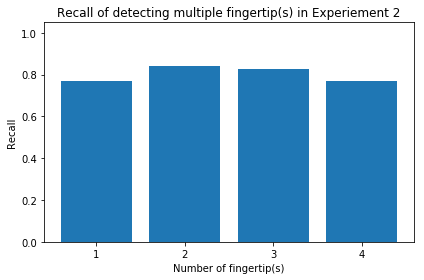

In [42]:
tips_detection_old, touch_detection_old, sum_fnum =ex2_result_evaluation(result)

In [ ]:
for i in range(len(result)):
    print(i)
    print(ex2data[i])
    print(result[i][0].TP/result[i][0].real_tn)
    result[i][0].show()
    

In [43]:
tips_detection_old.show()

Total detection: 1716
real_tn        : 1432
True  Positive : 1148
False Positive : 568
True  Negative : 0
False Negative : 284
recall : 0.801676
precision : 0.668998



In [44]:
touch_detection_old.show()

Total detection: 0
real_tn        : 0
True  Positive : 836
False Positive : 362
True  Negative : 206
False Negative : 312
recall : 0.728223
precision : 0.697830



In [24]:
# tips_detection_new, touch_detection_new, result_new = evaluate_list_file(ex2data,debug=True, new_parameter=True)

In [25]:
# tips_detection_new.show()

In [26]:
# touch_detection_new.show()

In [28]:
# data = 
# for i in range(len(result_old)):
#     result_old[i][0].show()

In [188]:
def hist_ex2(result_list):
    data = []
    data2 = []
    for i in range(len(result_list)):
        Matrix = result_list[i][0]
        data.append(Matrix.recall)
        Matrix = result_list[i][1]
        data2.append(Matrix.recall)
    
    fig, axs = plt.subplots()
    
    idx = np.arange(len(data))
    axs.bar(idx,data,0.35, label='Finger tips')
    axs.bar(idx+0.35,data2, 0.35, label='Touch')
    axs.set_xlabel('participants ID')
    axs.set_ylabel('Recall')
    axs.set_title('Recall graph of tips and touch detection of experiment2')
    axs.set_xticks(idx + 0.35 / 2)
    axs.set_xticklabels([str(i) for i in range(len(data))])
    axs.legend()
    #plt.title('Recall graph of tips detection of experiment2')
    #plt.xlabel('participants id')
    #plt.ylabel('Recall')   
    fig.tight_layout()
    plt.show()

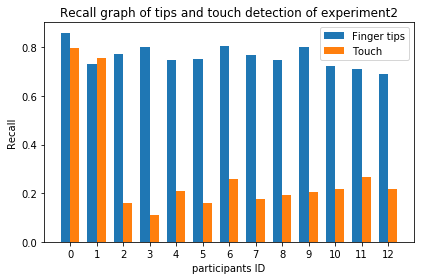

In [189]:
hist_ex2(result_old)

# label - > touching model

In [31]:
def touch_analysis(analyser, model, depth_frame, label_label, label_istouch, range_, debug = True,threathold =12):
    touch_detection = Confusion()
    for i in range_:
        current_label_label = label_label[i]
        current_label_istouch = label_istouch[i]
#         print(i)
#         print(current_label_label)
#         print(current_label_istouch)
#         print("--------------------")
        analyser.renew_depth(depth_frame[i])
        for j in range(len(current_label_label)):
            POINT = analyser.cloud[current_label_label[j][1], current_label_label[j][0]]
            is_touch = current_label_istouch[j]
            distance = np.linalg.norm(analyser.cloud_filter-POINT,axis = 1)
            AREA = analyser.cloud_filter[distance < 0.02]
            
            x_predicts = analyser.predict_return([AREA])
            
            y_predict = model.predict(x_predicts)
            if(y_predict[0][0]>=0.5):
                if(is_touch):
                    touch_detection.TPL.append(1)
                else:
                    touch_detection.FPL.append(1)
            else:
                if(not is_touch):
                    touch_detection.TNL.append(1)
                else:
                    touch_detection.FNL.append(1)
    return touch_detection
            

In [32]:
def touch_label(file,debug=False, new_parameter = False):
    results = []
    from keras.models import load_model
    model = load_model('depth_angle_model.hdf5')
    model._make_predict_function()
    total = 0
    total_true = 0
    for i in file:
        print("======================")
        print(i)
        print("======================")
        df, lp, lt, pc, tm = loading_touch(i)
        total += len(lt)
        total_true += reduce((lambda x, y: x + y),list(map(lambda x: len(x), lt)))
        analyser = HandShapeAnalysis.Depth2Finger(pc, tm)
        analyser.set_show(debug=False,finger_point_image=False, hull_image=False, detected_defect=False, cluster_point=False, possibility_modal=False)
        analyser.RANSAC = True

        
        if new_parameter:
            analyser.angel=40
    #         analyser.cloud_min=0.015
            analyser.combine_minimun_distance=0.03
            analyser.cluster_threshold_=30
        result = touch_analysis(analyser, model, df, lp, lt, range(len(df)), debug = debug)
        results.append(result)
    return total, total_true, results

In [ ]:
total, total_true, c = touch_label(ex2data)

In [ ]:
total

In [ ]:
total_true

In [ ]:
x = Confusion()
for i in c:
    i.show()
    x = x.combine(i)
    print(x.)

In [ ]:
x.show()